# Material Identification

## Acknowledgements

I would like to give credit to Madjek, Inc. in Amityville, NY who provided the facilities for data collection and helped to advise in the business case scenario for this project. Although this scenario is a fictitious one, they were still happy to serve as an example for this data investigation, and we thank them for their support.

## Objective

To develop a Covolutional Nueral Network that can properly identify material types for warehouse and scrap material handling.

## Business Problem

Our client Madjek, Inc. is a store fixture manufacturer who purchases a variety of sheet good materials for different jobs. They would like to install a material handling system which would keep track of their sheet good products in their warehouse.+ For the installation of this system, they would also like to eliminate barcodes and barcode scanners that would typically be used to track materials, so as to reduce the amount of employees required for material handling, as well as reduce human error in handling. In order to do this, they will need to have a system in place (using cameras and scanners) which would automatically recognize the type of material in a given situation. The system would need to recognize the material at certain intervals in material handling:

- When the material is offloaded from a truck and placed into the warehouse
- When the material is cut on the panel saw and then stored in with scrap cuts in the warehouse
- To serve as a quality control check at the CNC routers to confirm the correct material has been placed on the machine

The company has 4 main types of materials that they work with that they would like to have classified:

- MDF
- TFL / Particle Core with HPL
- Particle Core
- Veneer Core


## Defining Metrics

Ultimately our client would like the model to be as accurate as possible. They are looking for a accuracy rating that falls within six sigma standards, which ideally refers to a 99.999997% accuracy. This computer vision system is intended to be integrated into an automated material and inventory handling system, so any time a material is identified incorrectly, it has the strong possibility of being cut and sent out with the wrong material for production. Given this, there is no preference on whether the material identified is a false positive or a false negative, only that the prediction cannot be inaccurate.

The client also understands that achieving this ultimate goal will take iterations of the system in order to achieve the six sigma goal they are looking for. So for the first iteration of the system they intend to have workers at each identification interval to check the system for the first 90 days in production. Therefore, the first iteration of the computer vision network does not have to meet the six sigma goal but must attempt to get closer to that goal. We have agreed with the client to set a 70% accuracy rating goal for this iteration.

## The Dataset

The images in this dataset contains around 2000 images that were taken at varying view points in both the warehouse and the scrap racks. All images were taken on a Iphone 13 pro camera. Across the range of images, there are a variety of lighting conditions, as well as a variety of close up and far away images. The far away images were taken within the warehouse, and are used to identify an entire stack of material, where the material will be the same for the entire stack. The close up images vary for both the warehouse and the scrap racks, where the piece of material that is centered in the image is what is identified as the material type. 



Given the variation in the data, the standards that our client is shooting for are ha

All original images in the dataset are located in images/0_Madjek_NoClass. There are other folders in images which were part of preprocessing, please see the chart below for more information on each folder step
There is also a Data_image_target csv file, which contains a column for the image file name, and a column for the material type of the image.

| Folder Name  |  Description |
|---|---|
| 0_Madjek_NoClass  | Original images  |
| 1A_Madjek_Class  | Images sorted into folder hierarchy by class  |
| 1B_Madjek  | Images sorted into folder hierarchy by class and train, validation, and test sets  |
|  2A_Madjek_NoClass_Crop | Cropped images  |
| 2B_Madjek_Class_Crop  |  Cropped images sorted into folder hierarchy by class  |
| 2C_Madjek_Crop  |  Cropped images sorted into folder hierarchy by class and train, validation, and test sets |

Under the images folder, each folder has an initial number and letter where the number represents the iteration of preprocessed images and the letter represents the substage of the processing of those images. The original 0_Madjek_NoClass folder contains all of the original images for the project. A separate notebook named "Crop Images" was created in order to crop all original images and store the images in a new folder called "Madjek_Crop." Another notebook named "Train-Split-Multiclass-Images" was created to use the csv file to organize the images into subfolders by class (which were stored in the "Madjek_Class" folders) and then subsequently break the images into train, test, and validation sets (which were stored in the "Madjek" folders).

## Modeling

Our models included 3 base models, 2 regularized models, and 2 transfer learning models. Of all the CNN's we created, our last transfer learning model seemed to give the best results. This model is a Resnet50V2 model with data augmentation, dropout, and rescaling.

This model has a softmax activation function at the end and uses an adam optimizer for compiling.



## Reading and Analyzing the Data

We will start by importing the libraries required for the notebook and pulling in the data:

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set(rc={'savefig.dpi':300, 'figure.figsize':(12,8)})
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import os
import cv2
import argparse
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras.models import Sequential
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import datetime
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
import tensorflow_datasets as tfds
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_base
from lime import lime_image

In [2]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


In [3]:
# load the tensorboard notebook extension
%load_ext tensorboard

Lets take a look at some of the image files to get a better idea of the data we are working with.

In [89]:
# Create a function to show specified image files within a directory
def imgfileshow(filenames, directory, cols, rows):
    imgs = []
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(12,12))
    for count, IM in enumerate(filenames):
        img = image.load_img((directory + '/' + IM), target_size=None)
        ax = axes[count//cols][count%cols]
        ax.imshow(img)
        ax.grid(False)
        ax.set_axis_off()
        imgs.append(img)

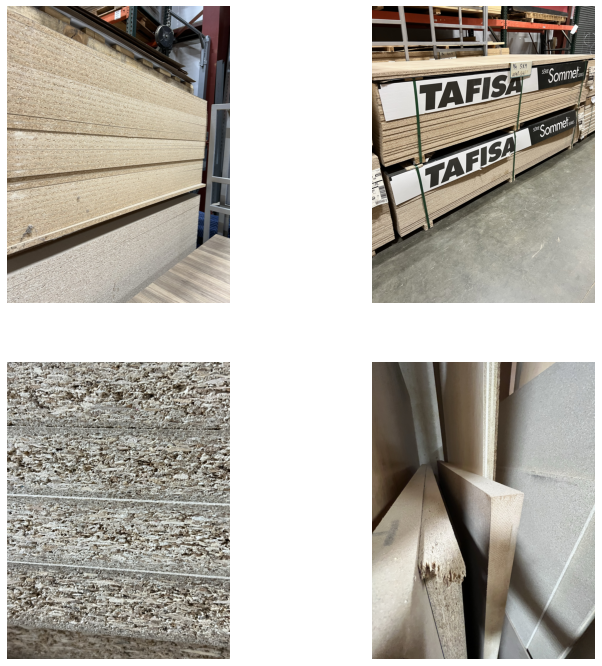

In [106]:
# Images selected to load
IMGtoLoad = ['IMG_1114.jpeg', 'IMG_1125.jpeg', 'IMG_1583.jpeg', 'IMG_1743.jpeg']

# Run function to show selected images in a 2 x 2 grid
imgfileshow(IMGtoLoad, f'images/0_Madjek_NoClass', 2, 2)

plt.savefig('Visualizations/Sample-Original.png', bbox_inches='tight')        
plt.show();

We have a couple problems in these images that we will have to deal with. 

- The images are large (1536 x 2048), we will need to scale them down in order to reduce the modeling time
- Some images contain one piece of material and others contain a stack of material. By looking at the corresponding labels for the images, it looks like the material at the center of the image is what is being identified. We will need to crop the images to only include the center area of the image for proper identification
- Some images are close up and some images are taken far away. Not sure how we will deal with this, but will have to come back to it.



Lets take a look at the proportions of each of the classes we have in the csv file

In [6]:
# Load csv data into pandas dataframe and show
df_target = pd.read_csv('Data_Image_Target.csv')
df_target

IMG  Mat
0     IMG_1089   PC
1     IMG_1090   PC
2     IMG_1091   PC
3     IMG_1092   PC
4     IMG_1093   PC
...        ...  ...
2056  IMG_3148  TFL
2057  IMG_3149  TFL
2058  IMG_3150  TFL
2059  IMG_3151  TFL
2060  IMG_3152  TFL

[2061 rows x 2 columns]

In [7]:
# Show number of data points of each class
print(df_target['Mat'].value_counts())

TFL    825
PC     619
MDF    309
VC     308
Name: Mat, dtype: int64


In [8]:
# Calculate percentages for each class
Value_counts = df_target['Mat'].value_counts(normalize=True)*100
Vcts = [round(item, 2) for item in list(Value_counts.to_dict().values())]
Vcts

[40.03, 30.03, 14.99, 14.94]

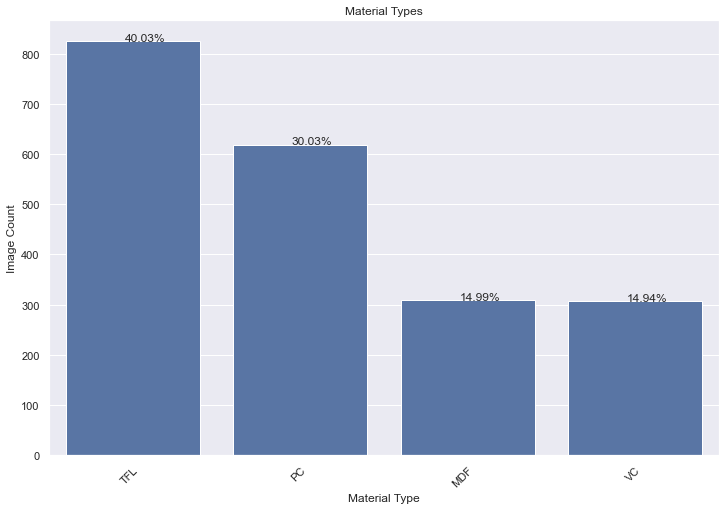

In [108]:
# Plot class types and percentages in barplot

Mat_type = df_target['Mat'].value_counts(sort=True)
Value_counts = df_target['Mat'].value_counts(normalize=True)*100
vctsdict = Value_counts.to_numpy()

ax = sns.barplot(x=Mat_type.index, y=Mat_type.values, color='b')
ax.set(xlabel='Material Type', ylabel='Image Count', title='Material Types')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

for val, p in enumerate(ax.patches):
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate((str(Vcts[val]) + '%'), (x, y), size = 12)

plt.savefig('Visualizations/Material-Types.png', bbox_inches='tight')        
plt.show();

The TFL class seems to have the most amount of data points at 40% of the entire dataset, with PC coming in second at 30% and MDF and VC coming in at 15%. So it seems that we have a slight class imbalance between them all. We may want to implement some techniques that will reduce the issues of this imbalance in the dataset.

## Preprocessing Data

### Check for nulls and total count

Lets just double check the target data for any nulls or problems in that set before moving forward.

In [10]:
# check csv file for any nulls
df_target.isnull().sum()

IMG    0
Mat    0
dtype: int64

In [11]:
# Show description on csv file data
df_target.describe()

IMG   Mat
count       2061  2061
unique      2061     4
top     IMG_1556   TFL
freq           1   825

In [12]:
# get total number of files in original folder to confirm count matches to csv file
dir_path = r'C:\Users\Tim\Documents\Flatiron\Phase_4\Material-Identification\images\0_Madjek_NoClass'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 2061


There are no nulls in the csv file and the count of images matches the count of rows in the csv file. 

### Sample crop and resize

We will start by cropping the sample images that we pulled from the dataset as reference to how we intend to crop the images. The intention behind cropping is not to focus on the image size itself, but to crop it enough so as to focus on only the center of each image. Even in the sample images that we pulled, there are multiple materials showing due to the materials being stacked close to one another. We want to generally only have the material that is in the center of the image within the frame of the image.

In [13]:
# Converts the image file into a tensor
sam_imgs = [tf.io.decode_image((tf.io.read_file(f'images/0_Madjek_NoClass/{IM}')), channels=3, dtype=tf.dtypes.float32) for IM in IMGtoLoad]

In [14]:
# Crop the sample images using a pre determined crop ratio
crpimgs = tf.image.central_crop(sam_imgs, 0.4)

In [91]:
# Create a function to show tensor images
def tensorimgshow(filenames, cols, rows):
    imgs = []
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(12,12))
    for count, IM in enumerate(filenames):
        img = image.array_to_img(IM)
        ax = axes[count//cols][count%cols]
        ax.imshow(img)
        ax.grid(False)
        ax.set_axis_off()
        imgs.append(img)

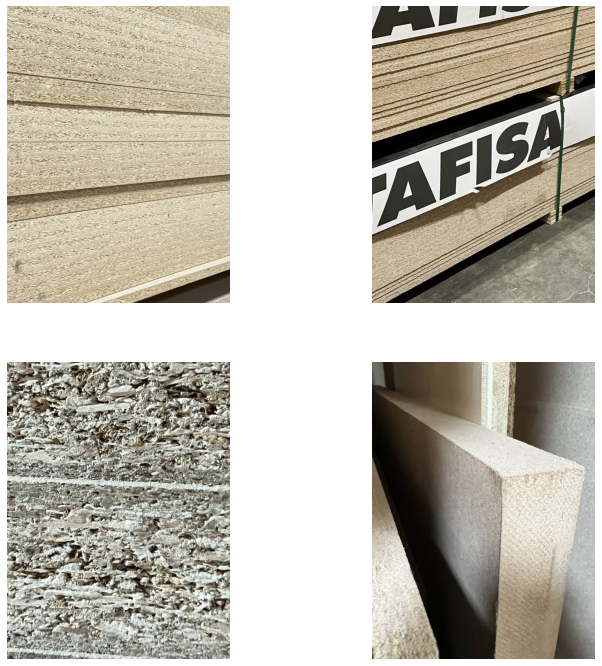

In [107]:
# Run function to show cropped images
tensorimgshow(crpimgs, 2, 2)

plt.savefig('Visualizations/Sample-Cropped.png', bbox_inches='tight')        
plt.show();

In order to futher improve processing time, we will also resize the dpi for the images

In [17]:
# Set image height and width in pixels
img_height = 256
img_width = 192

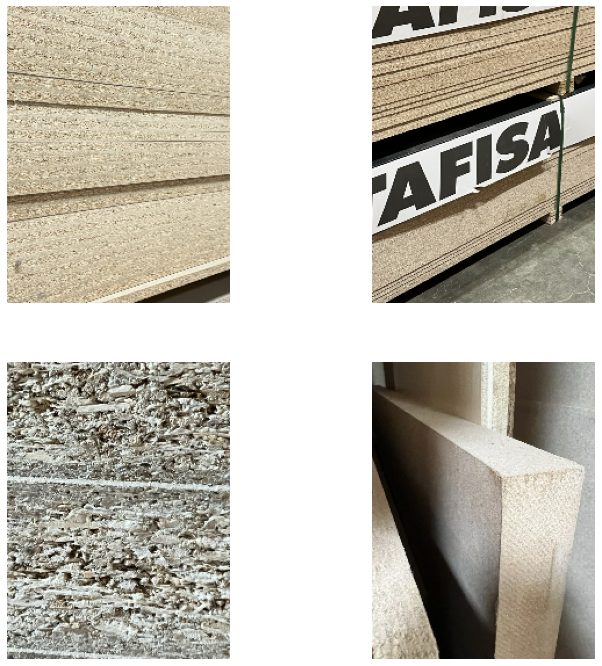

In [93]:
# resize images to new image height and width
crpsizeimgs = tf.image.resize(crpimgs, [img_height, img_width])
tensorimgshow(crpsizeimgs, 2, 2)

### Balance classes

Last but not least, we do have a slight class imbalance in the dataset, so we will want to adjust the data for this. We are going to calculate the weight for each class and use that as one of our baseline models to see how it does.

In [19]:
# total number of items
total = len(df_target)

In [20]:
# Determine the value counts of each class
Class_total = list(df_target['Mat'].value_counts())

In [21]:
# Scaling by total/4 to keep the loss to a similar magnitude 
# multiplied by a fraction of the total for each class to determine the class weight.
weight_for_0 = (1 / Class_total[0]) * (total / 4.0)
weight_for_1 = (1 / Class_total[1]) * (total / 4.0)
weight_for_2 = (1 / Class_total[2]) * (total / 4.0)
weight_for_3 = (1 / Class_total[3]) * (total / 4.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))

Weight for class 0: 0.62
Weight for class 1: 0.83
Weight for class 2: 1.67
Weight for class 3: 1.67


## Preparing the Data for Modeling

Our images have been split beforehand into separate train, test, and validation folders. One thing we will need to do is assign these images to the proper variables in order to process them through our Convolutional Neural Network.

In [22]:
# Set batch size
batch_size =  32

In [23]:
# Set train/test/val directories
base_model0_train_dir = 'images/1B_Madjek/train/'
base_model0_test_dir = 'images/1B_Madjek/test/'
base_model0_val_dir = 'images/1B_Madjek/val/'

In [24]:
# transfer data from directories to batches

base_model0_train_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model0_train_dir,
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

base_model0_test_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model0_test_dir,
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

base_model0_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model0_val_dir,                                               
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

Found 1648 files belonging to 4 classes.
Found 210 files belonging to 4 classes.
Found 203 files belonging to 4 classes.


In [25]:
# Print train data shapes separated into image and label batches
for image_batch, labels_batch in base_model0_train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 192, 3)
(32, 4)


In [26]:
# Calculate number of classes
classes=list(base_model0_train_data.class_names)
num_classes=len(classes)
num_classes

4

In [27]:
# Print class labels
classes

['MDF', 'PC', 'TFL', 'VC']

## Baseline CNNs

### Base Model 0

In [28]:
# Create baseline model
base_model0 = models.Sequential()

# Add the appropriate layers
base_model0.add(layers.experimental.preprocessing.Rescaling(1./255))
base_model0.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(img_height, img_width, 3)))
base_model0.add(layers.MaxPooling2D(2, 2))

base_model0.add(layers.Conv2D(32, (4, 4), activation='relu'))
base_model0.add(layers.MaxPooling2D(2, 2))

base_model0.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model0.add(layers.MaxPooling2D(2, 2))

base_model0.add(layers.Flatten())
base_model0.add(layers.Dense(64, activation='relu'))
base_model0.add(layers.Dense(num_classes, activation='softmax'))



In [29]:
# Compile the model
base_model0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer='adam',
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [30]:
# Set the number of epochs and fit base model 0
epochs=20
bm0_history = base_model0.fit(
  base_model0_train_data,
  validation_data=base_model0_val_data,
  epochs=epochs
)

Epoch 1/20
52/52 [==============================] - 73s 1s/step - loss: 1.3052 - categorical_accuracy: 0.3786 - val_loss: 1.1908 - val_categorical_accuracy: 0.4286
Epoch 2/20
52/52 [==============================] - 68s 1s/step - loss: 1.1459 - categorical_accuracy: 0.4624 - val_loss: 1.1113 - val_categorical_accuracy: 0.4729
Epoch 3/20
52/52 [==============================] - 68s 1s/step - loss: 1.0220 - categorical_accuracy: 0.5285 - val_loss: 1.1609 - val_categorical_accuracy: 0.4877
Epoch 4/20
52/52 [==============================] - 69s 1s/step - loss: 0.8839 - categorical_accuracy: 0.6129 - val_loss: 1.2030 - val_categorical_accuracy: 0.4926
Epoch 5/20
52/52 [==============================] - 69s 1s/step - loss: 0.7216 - categorical_accuracy: 0.7002 - val_loss: 1.3019 - val_categorical_accuracy: 0.4286
Epoch 6/20
52/52 [==============================] - 68s 1s/step - loss: 0.4753 - categorical_accuracy: 0.8046 - val_loss: 1.5141 - val_categorical_accuracy: 0.5222
Epoch 7/20
52/52

In [31]:
# Evaluate base model 0 on test data
base_model0.evaluate(base_model0_test_data)

7/7 [==============================] - 1s 130ms/step - loss: 4.0295 - categorical_accuracy: 0.5000


[4.029536247253418, 0.5]

In [32]:
# Return a summary of base model 0
base_model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 192, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 190, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 95, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 92, 32)       16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 22, 64)        0

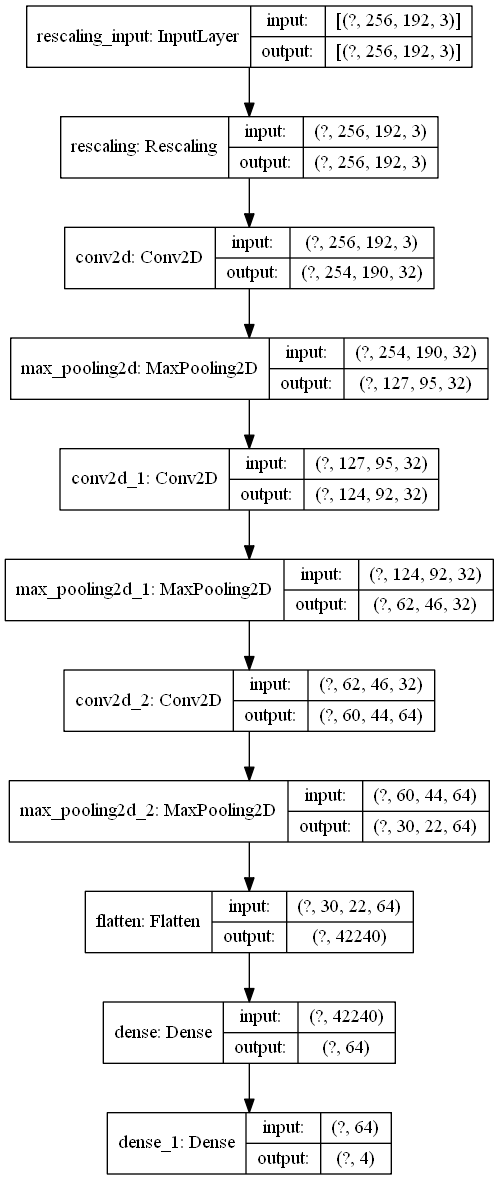

In [33]:
# Return image of model's architecture
plot_model(base_model0, show_shapes=True, show_layer_names=True)

In [34]:
# Define a function to show classification report and confusion matrix
def show_classification_report_and_confusion_matrix(model, 
                                                    batchDataset_test_data, 
                                                    classes, 
                                                    cm_cmap, 
                                                    cr_cmap, 
                                                    cm_title, 
                                                    cr_title):
    
    # Start with two empty numpy arrays for y_pred and y_test
    y_pred = np.array([])
    y_test =  np.array([])

    # split prediction and true values
    for x, y in batchDataset_test_data:
        
        # Make numpy array of predictions, take max prediction from each row, and convert to list of values
        y_pred = np.concatenate([y_pred,
                       np.argmax(model.predict(x), axis = -1)])
        
        # Make numpy array of true labels and convert to list
        y_test = np.concatenate([y_test, np.argmax(y.numpy(), axis=-1)])
    
    # Display a confusion matrix using the test and predicted values
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap = cm_cmap)
    disp.ax_.set_title(cm_title)
    disp.ax_.xaxis.labelpad = 20
    plt.grid(False)
    plt.show()
    
    # Create dataframe of classification report
    df = pd.DataFrame(classification_report(y_test, 
                                        y_pred, 
                                        target_names=classes, 
                                        digits=2,
                                        output_dict=True)).T
    
    # Create fig and ax for classification report
    fig, ax = plt.subplots()

    # Mask all classification report cells except class metric cells and create heatmap
    mask = np.zeros((df.shape))
    mask[:, -1] = True
    mask[4:7, :] = True
    ax = sns.heatmap(pd.DataFrame(df), mask=mask, vmin=0, vmax=1, cmap=cr_cmap, annot=True, fmt='.2f')

    # Mask all classification report cells except class support cells and create heatmap
    mask = np.zeros(df.shape)
    mask[:,:3] = True 
    mask[5:7, :] = True
    ax = sns.heatmap(df, mask=mask, annot=True, cmap='Greys', cbar=False, fmt='.2f') 

    # Mask all classification report cells except macro avg and weighted avg rows and create heatmap
    mask = np.zeros(df.shape)
    mask[0:5, :] = True
    ax = sns.heatmap(df, mask=mask, annot=True, cmap='Greys', cbar=False, fmt='.2f') 

    # Specify classification report title and ytick direction
    plt.title(cr_title)
    plt.yticks(rotation = 0);

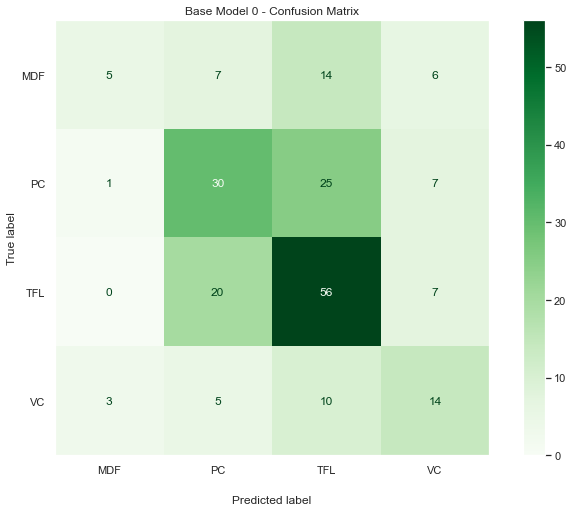

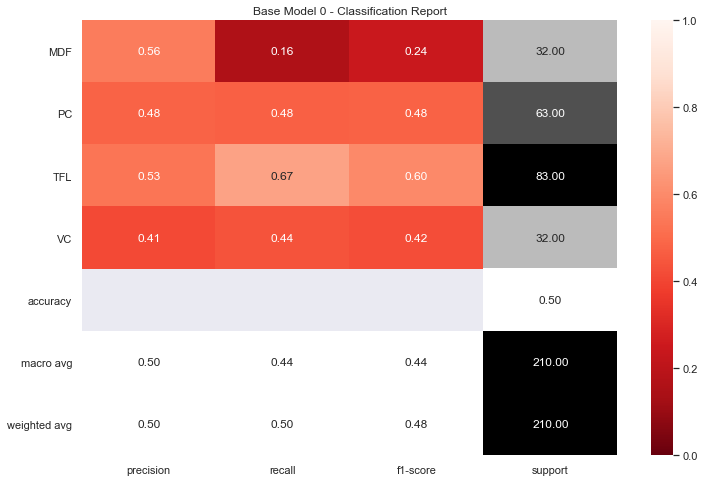

In [35]:
# Show classification report and confusion matrix
show_classification_report_and_confusion_matrix(base_model0, 
                                                base_model0_test_data, 
                                                classes, 
                                                'Greens', 
                                                'Reds_r', 
                                                'Base Model 0 - Confusion Matrix', 
                                                'Base Model 0 - Classification Report')

In [36]:
# Define a function to show the graph of train loss vs validation loss and the graph of train accuracy vs validation accuracy
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_categorical_accuracy'])
    plt.plot(history['categorical_accuracy'])
    plt.legend(['val_categorical_accuracy', 'categorical_accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Categorical Accuracy')
    plt.show()

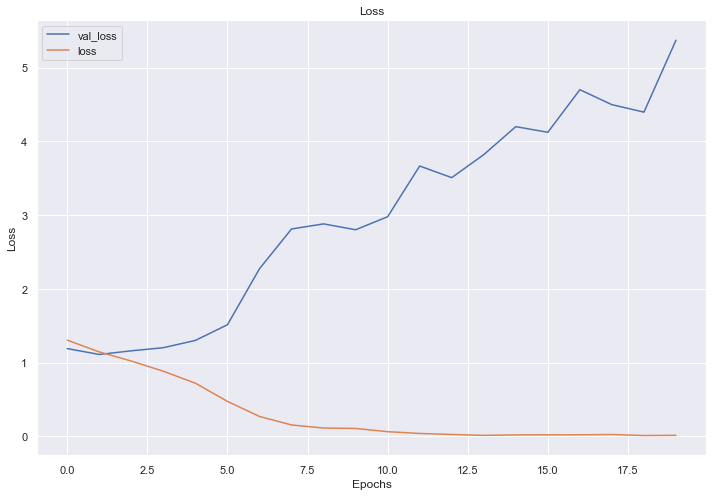

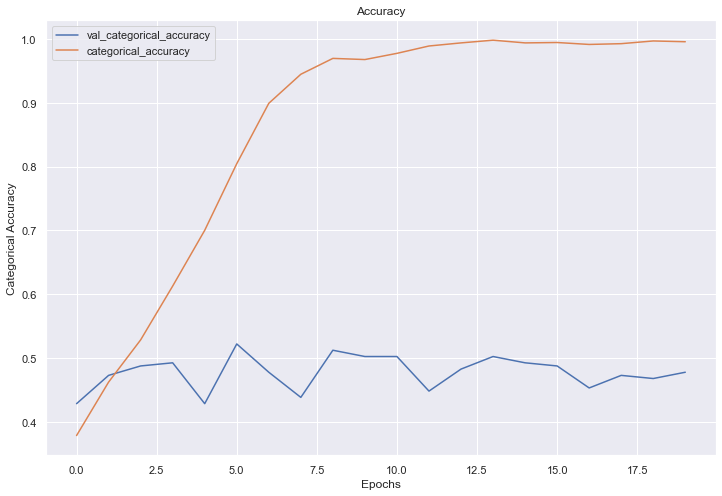

In [37]:
# Show model loss and model accuracy
visualize_training_results(bm0_history)

Our accuracy increases but our validation accuracy stays about the same. It is concerning that after the first epoch, the train loss decreases and the validation loss increases. We will need to find a way to remedy that.

### Base Model 1

After cropping we looked through each of the images individually confirm that they showed the material that was identified originally. Photos were deleted from the set that had:
- More than one material in the image frame
- an material which did not match the true label
- did not show the edge of the material, which is requiired for identification

Images removed were the following:

In [38]:
imgs_removed = ['IMG_2809', 'IMG_2810', 'IMG_1832', 'IMG_1833', 'IMG_2005', 'IMG_2049', 'IMG_2386', 
                'IMG_2415', 'IMG_2529', 'IMG_2532', 'IMG_2535', 'IMG_2536', 'IMG_2537', 'IMG_1480', 
                'IMG_1486', 'IMG_1487', 'IMG_1488', 'IMG_1489', 'IMG_1490', 'IMG_1491', 'IMG_1492', 
                'IMG_1493', 'IMG_1536', 'IMG_1537', 'IMG_1538', 'IMG_1542', 'IMG_1795', 'IMG_1796', 
                'IMG_1814', 'IMG_1904', 'IMG_2204', 'IMG_2249', 'IMG_2550', 'IMG_2573', 'IMG_1609',
                'IMG_1650', 'IMG_1694', 'IMG_1713', 'IMG_1829', 'IMG_2088', 'IMG_2417', 'IMG_2548', 
                'IMG_2610', 'IMG_2817', 'IMG_2826']

In [39]:
# Set train/test/val directories
base_model1_train_dir = 'images/2C_Madjek_Crop/train/'
base_model1_test_dir = 'images/2C_Madjek_Crop/test/'
base_model1_val_dir = 'images/2C_Madjek_Crop/val/'

In [40]:
# transfer data from directories to batches

base_model1_train_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model1_train_dir,
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

base_model1_test_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model1_test_dir,
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42,
    shuffle = False)

base_model1_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model1_val_dir,                                               
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42,
    shuffle=False)

Found 1609 files belonging to 4 classes.
Found 206 files belonging to 4 classes.
Found 199 files belonging to 4 classes.


For our future models we will also apply rescaling to standardize all of the images to improve the gradient descent of our models.

In [41]:
# Create baseline model
base_model1 = models.Sequential()

# Add the appropriate layers
base_model1.add(layers.experimental.preprocessing.Rescaling(1./255))
base_model1.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', 
                        input_shape=(img_height, img_width, 3)))
base_model1.add(layers.MaxPooling2D(2, 2))

base_model1.add(layers.Conv2D(32, (4, 4), activation='relu'))
base_model1.add(layers.MaxPooling2D(2, 2))

base_model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model1.add(layers.MaxPooling2D(2, 2))

base_model1.add(layers.Flatten())
base_model1.add(layers.Dense(64, activation='relu'))
base_model1.add(layers.Dense(num_classes, activation='softmax'))



In [42]:
# Compile the model
base_model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer='adam',
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [43]:
# Fit base model 1
bm1_history = base_model1.fit(
  base_model1_train_data,
  validation_data=base_model1_val_data,
  epochs=epochs
)

Epoch 1/20
51/51 [==============================] - 41s 803ms/step - loss: 1.2515 - categorical_accuracy: 0.3903 - val_loss: 1.2047 - val_categorical_accuracy: 0.4472
Epoch 2/20
51/51 [==============================] - 40s 777ms/step - loss: 1.2074 - categorical_accuracy: 0.4394 - val_loss: 1.1670 - val_categorical_accuracy: 0.4623
Epoch 3/20
51/51 [==============================] - 40s 784ms/step - loss: 1.1015 - categorical_accuracy: 0.5009 - val_loss: 1.1814 - val_categorical_accuracy: 0.4623
Epoch 4/20
51/51 [==============================] - 44s 871ms/step - loss: 0.9752 - categorical_accuracy: 0.5656 - val_loss: 1.2107 - val_categorical_accuracy: 0.4874
Epoch 5/20
51/51 [==============================] - 45s 879ms/step - loss: 0.8098 - categorical_accuracy: 0.6712 - val_loss: 1.3053 - val_categorical_accuracy: 0.3920
Epoch 6/20
51/51 [==============================] - 41s 800ms/step - loss: 0.6356 - categorical_accuracy: 0.7328 - val_loss: 1.6801 - val_categorical_accuracy: 0.437

In [44]:
# Evaluate base model 1 on test data
base_model1.evaluate(base_model1_test_data)

7/7 [==============================] - 1s 182ms/step - loss: 4.5473 - categorical_accuracy: 0.3398


[4.547306060791016, 0.33980581164360046]

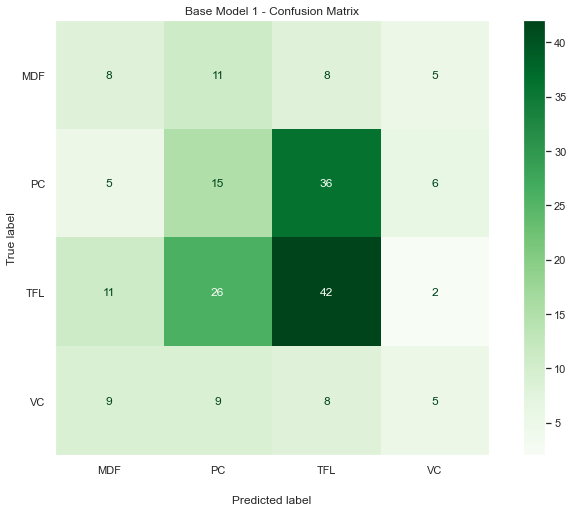

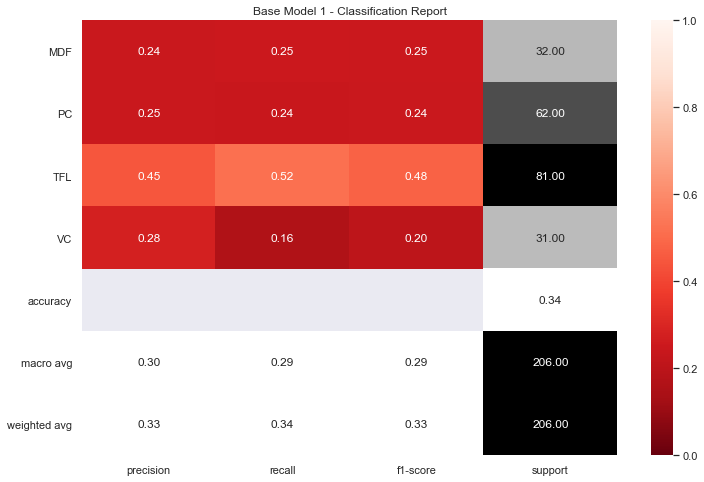

In [45]:
# Show classification report and confusion matrix
show_classification_report_and_confusion_matrix(base_model1, 
                                                base_model1_test_data, 
                                                classes, 
                                                'Greens', 
                                                'Reds_r', 
                                                'Base Model 1 - Confusion Matrix', 
                                                'Base Model 1 - Classification Report')

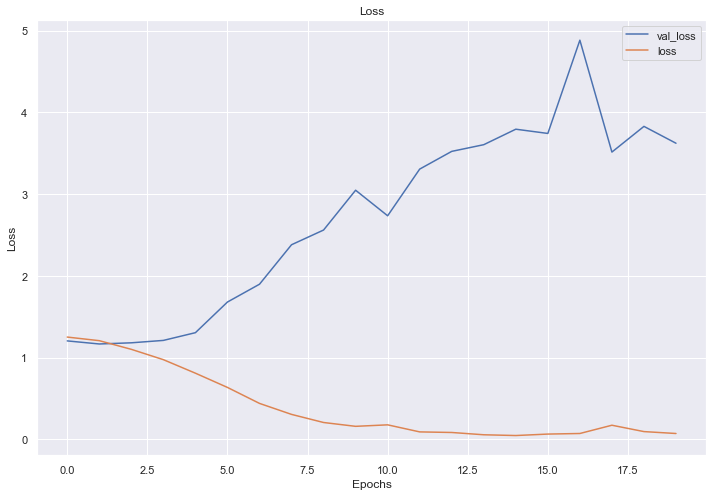

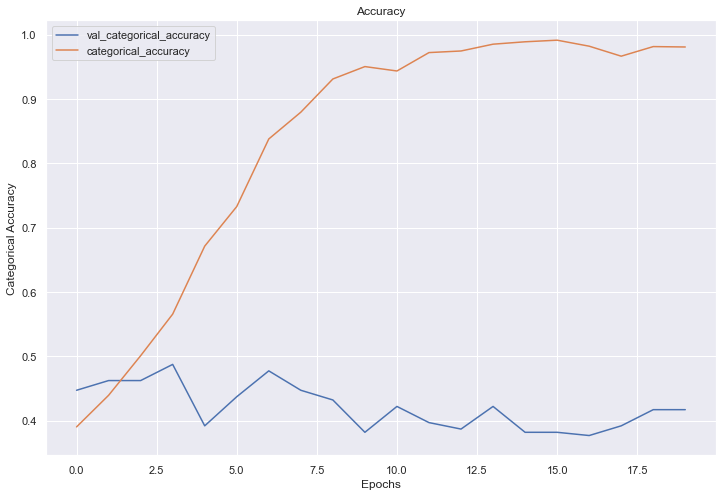

In [46]:
# Show plot of model loss and model accuracy
visualize_training_results(bm1_history)

Looks like we received similar results in this base model in comparison to the last one. But in this one, we received slightly better results for the validation accuracy by around 8% and a better validation loss as well. The test accuracy is a hair lower in this model, but it seems overall that Base model 1 performed better than the original base model. So we will move forward with base model 1 in our future models.

## CNN regularization model with Standardized data, Data Augmentation and Dropout

One of the largest problems we have had in all of the base models is overfitting. The train data quickly overfits and provides terrible results for both validation and test accuracy. The next model we will create will be a model that integrates dropout layers at the end so as to regularize the data and prevent such heavy overfitting.

Also, considering that we are attempting to solve a image classification problem, we will integrate some preprocessing layers into the following model. A rescaling layer in order to normalize the values in the data, and data augmentation layers which will augment the data in an effort to introduce a similar variety to the train data to improve performance.

Lastly, when fitting we will make sure to include the class weights that we had calculated in the data preprocessing so as to offset the class imbalance that exists in the dataset currently.

In [95]:
# Set up early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_categorical_accuracy', mode='min', patience=5)
lr_redox = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5)
log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, lr_redox, tensorboard_callback]

### Reg Model 0

In [48]:
# Augment data prior to feeding into model
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Create regularized model with dropout
reg_model0 = models.Sequential([data_augmentation])

# Add the appropriate layers
reg_model0.add(layers.experimental.preprocessing.Rescaling(1./255))
reg_model0.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', 
                        input_shape=(img_height, img_width, 3)))
reg_model0.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model0.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
reg_model0.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model0.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
reg_model0.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model0.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
reg_model0.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model0.add(layers.Flatten())
reg_model0.add(layers.Dense(512, activation='relu'))
reg_model0.add(layers.Dropout(0.3))
reg_model0.add(layers.Dense(512, activation='relu'))
reg_model0.add(layers.Dropout(0.3))
reg_model0.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
reg_model0.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [49]:
# Fit regularization model 0 with class weight and callbacks
rm0_history = reg_model0.fit(
  base_model1_train_data,
  validation_data=base_model1_val_data,
  epochs=epochs,
  class_weight=class_weight,
  callbacks=callbacks
)

Epoch 1/20
 1/51 [..............................] - ETA: 0s - loss: 1.7950 - categorical_accuracy: 0.2500WARNING:tensorflow:From C:\Users\Tim\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
51/51 [==============================] - 42s 833ms/step - loss: 1.4641 - categorical_accuracy: 0.4034 - val_loss: 1.3323 - val_categorical_accuracy: 0.4020
Epoch 2/20
51/51 [==============================] - 42s 822ms/step - loss: 1.4130 - categorical_accuracy: 0.4040 - val_loss: 1.3019 - val_categorical_accuracy: 0.4221
Epoch 3/20
51/51 [==============================] - 41s 798ms/step - loss: 1.3819 - categorical_accuracy: 0.4164 - val_loss: 1.2987 - val_categorical_accuracy: 0.4221
Epoch 4/20
51/51 [==============================] - 41s 802ms/step - loss: 1.3616 - categorical_accuracy: 0.41

In [50]:
# Evaluate regularization model 0 on test data
reg_model0.evaluate(base_model1_test_data)

7/7 [==============================] - 1s 171ms/step - loss: 1.2629 - categorical_accuracy: 0.4903


[1.2629224061965942, 0.4902912676334381]

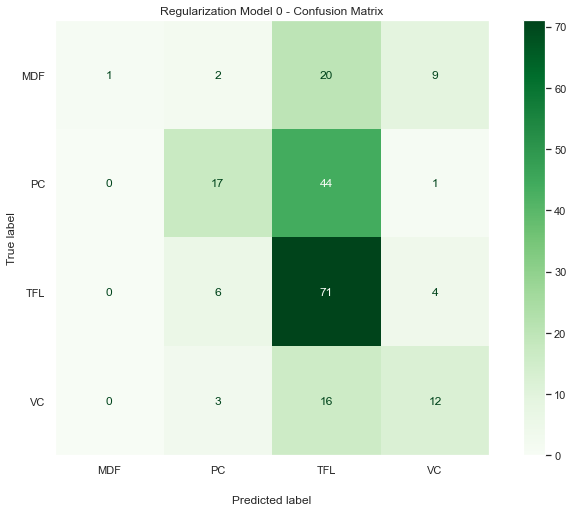

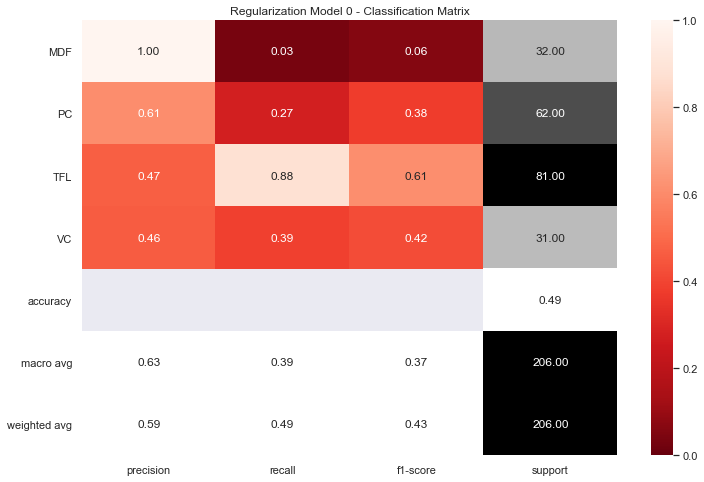

In [51]:
# Show classification report and confusion matrix
show_classification_report_and_confusion_matrix(reg_model0, 
                                                base_model1_test_data, 
                                                classes, 
                                                'Greens', 
                                                'Reds_r', 
                                                'Regularization Model 0 - Confusion Matrix', 
                                                'Regularization Model 0 - Classification Matrix')

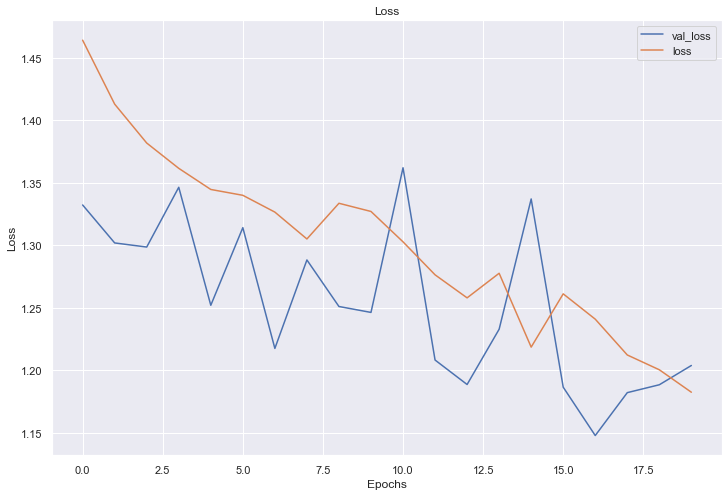

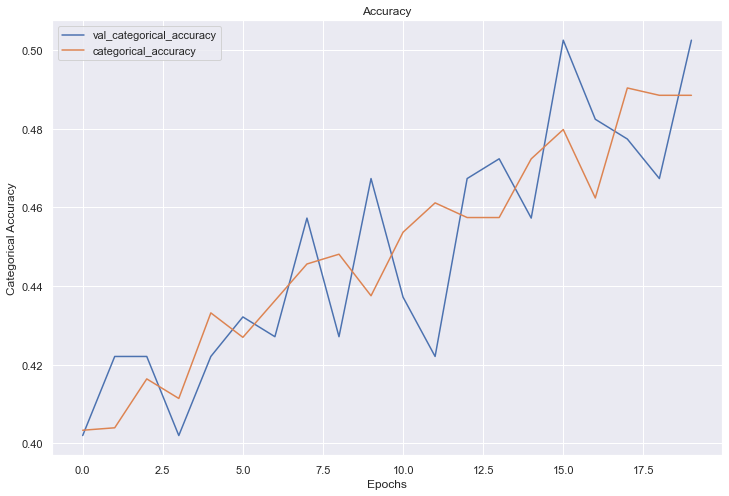

In [52]:
# Show plot of model loss and model accuracy
visualize_training_results(rm0_history)

Looks like we were able to stabilize the validation loss by applying data augmentation and dropout to the model

### Reg Model 1

Lets try and attempt to create additional dropout layers and image augmentation layers in an effort to show even more increased performance. We will also increase the epochs and add callbacks in the model to stop the model when it is required

In [53]:
# Augment data prior to feeding into model
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
  layers.experimental.preprocessing.RandomTranslation((-0.2, 0.2), (-0.2, 0.2))
])

# Create regularized model with dropout
reg_model1 = models.Sequential([data_augmentation])

# Add the appropriate layers
reg_model1.add(layers.experimental.preprocessing.Rescaling(1./255))
reg_model1.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', 
                        input_shape=(img_height, img_width, 3)))
reg_model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model1.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
reg_model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model1.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
reg_model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model1.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
reg_model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model1.add(layers.Flatten())
reg_model1.add(layers.Dense(512, activation='relu'))
reg_model1.add(layers.Dropout(0.3))
reg_model1.add(layers.Dense(512, activation='relu'))
reg_model1.add(layers.Dropout(0.3))
reg_model1.add(layers.Dense(512, activation='relu'))
reg_model1.add(layers.Dropout(0.3))
reg_model1.add(layers.Dense(512, activation='relu'))
reg_model1.add(layers.Dropout(0.3))
reg_model1.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
reg_model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [54]:
# Increase number of epochs
epochs = 50

In [55]:
# Fit regularization model 1
rm1_history = reg_model1.fit(
    base_model1_train_data,
    validation_data=base_model1_val_data,
    epochs=epochs,
    class_weight=class_weight,
    callbacks=callbacks
)

Epoch 1/50
51/51 [==============================] - 44s 868ms/step - loss: 1.5083 - categorical_accuracy: 0.3940 - val_loss: 1.3191 - val_categorical_accuracy: 0.4020
Epoch 2/50
51/51 [==============================] - 44s 871ms/step - loss: 1.4402 - categorical_accuracy: 0.4009 - val_loss: 1.2759 - val_categorical_accuracy: 0.4121
Epoch 3/50
51/51 [==============================] - 45s 885ms/step - loss: 1.4393 - categorical_accuracy: 0.3996 - val_loss: 1.3150 - val_categorical_accuracy: 0.4020
Epoch 4/50
51/51 [==============================] - 49s 966ms/step - loss: 1.4273 - categorical_accuracy: 0.4046 - val_loss: 1.3107 - val_categorical_accuracy: 0.4221
Epoch 5/50
51/51 [==============================] - 44s 872ms/step - loss: 1.4332 - categorical_accuracy: 0.4096 - val_loss: 1.3108 - val_categorical_accuracy: 0.4070
Epoch 6/50
51/51 [==============================] - 44s 853ms/step - loss: 1.4005 - categorical_accuracy: 0.4071 - val_loss: 1.2771 - val_categorical_accuracy: 0.432

In [56]:
# Return a summary of our model
reg_model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 256, 192, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 256, 192, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 254, 190, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 127, 95, 16)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 125, 93, 64)       9280      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 62, 46, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 60, 44, 128)      

In [57]:
# Evaluate regularization model 1 on test data
reg_model1.evaluate(base_model1_test_data)

7/7 [==============================] - 1s 171ms/step - loss: 1.3191 - categorical_accuracy: 0.3981


[1.3191159963607788, 0.3980582654476166]

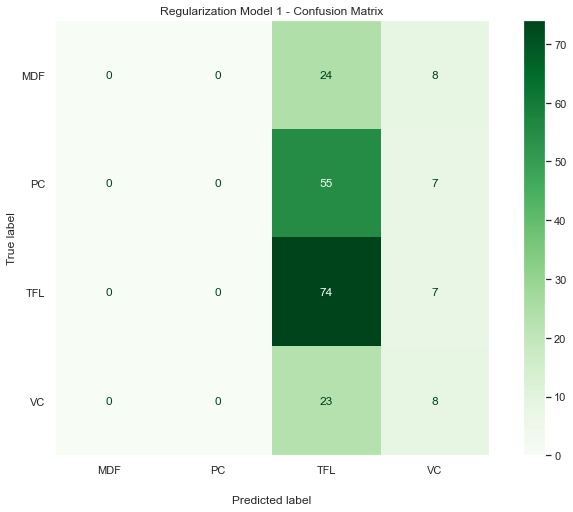

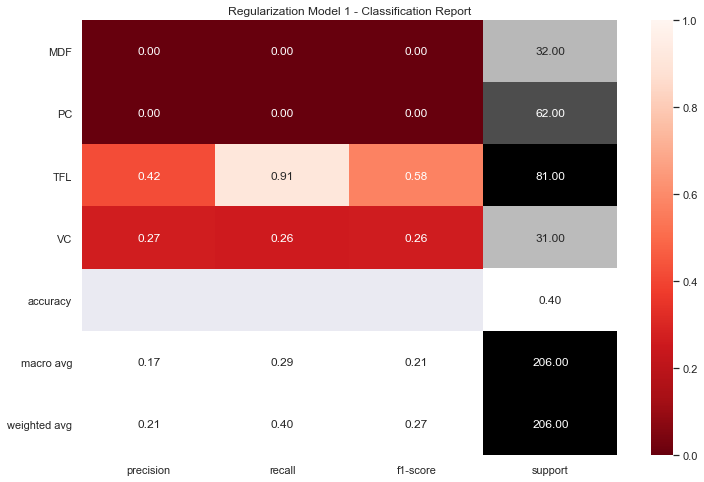

In [58]:
# Show classification report and confusion matrix
show_classification_report_and_confusion_matrix(reg_model1, 
                                                base_model1_test_data, 
                                                classes, 
                                                'Greens', 
                                                'Reds_r', 
                                                'Regularization Model 1 - Confusion Matrix',
                                                'Regularization Model 1 - Classification Report')

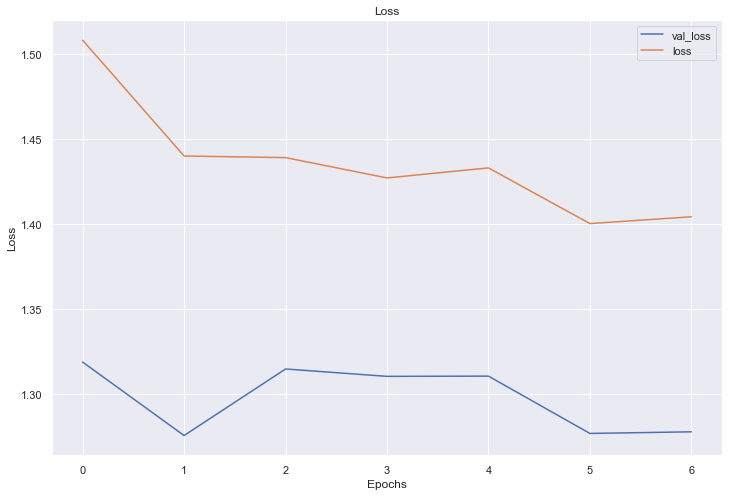

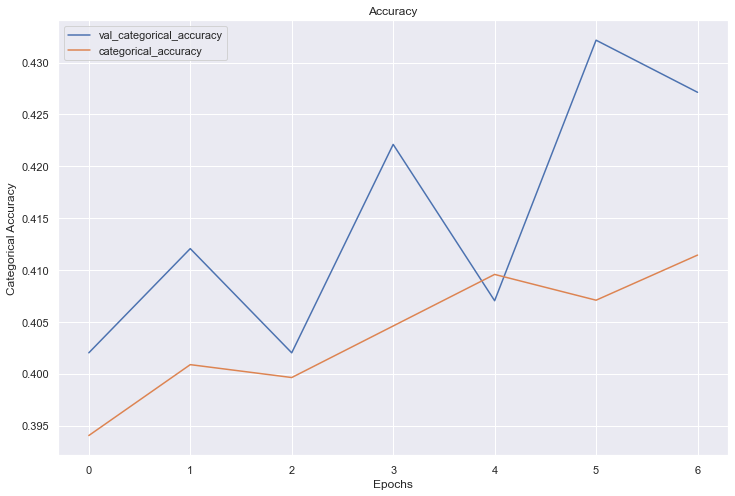

In [59]:
# Show plot of model loss and model accuracy
visualize_training_results(rm1_history)

## Transfer Learning Model 0

We could try to integrate a already trained model to see how it would perform on this complex problem.

In [60]:
# Import ResNet50
from keras.applications import ResNet50V2

# Set ResNet50 to base variable
cnn_base = ResNet50V2(weights='imagenet', 
                 include_top=False,
                 input_shape=(img_height, img_width, 3))

# Create base transfer model
transfer_model0 = models.Sequential()
transfer_model0.add(cnn_base)
transfer_model0.add(layers.Flatten())
transfer_model0.add(layers.Dense(64, activation='relu'))
transfer_model0.add(layers.Dense(128, activation='relu'))
transfer_model0.add(layers.Dense(256, activation='relu'))
transfer_model0.add(layers.Dense(128, activation='relu'))
transfer_model0.add(layers.Dense(num_classes, activation='softmax'))

cnn_base.trainable = False


In [61]:
# Compile the model
transfer_model0.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [62]:
# Fit transfer model 0
tm0_history = transfer_model0.fit(
  base_model1_train_data,
  validation_data=base_model1_val_data,
  epochs=epochs,
  class_weight=class_weight,
  callbacks=callbacks
)

Epoch 1/50
51/51 [==============================] - 71s 1s/step - loss: 165.0312 - categorical_accuracy: 0.3499 - val_loss: 34.8757 - val_categorical_accuracy: 0.2965
Epoch 2/50
51/51 [==============================] - 73s 1s/step - loss: 13.8530 - categorical_accuracy: 0.3922 - val_loss: 1.8577 - val_categorical_accuracy: 0.3920
Epoch 3/50
51/51 [==============================] - 68s 1s/step - loss: 1.6205 - categorical_accuracy: 0.3947 - val_loss: 1.3480 - val_categorical_accuracy: 0.4020
Epoch 4/50
51/51 [==============================] - 69s 1s/step - loss: 1.4520 - categorical_accuracy: 0.4164 - val_loss: 1.4127 - val_categorical_accuracy: 0.4020
Epoch 5/50
51/51 [==============================] - 72s 1s/step - loss: 1.4617 - categorical_accuracy: 0.4083 - val_loss: 1.3890 - val_categorical_accuracy: 0.4020
Epoch 6/50
51/51 [==============================] - 73s 1s/step - loss: 1.4393 - categorical_accuracy: 0.3978 - val_loss: 1.3208 - val_categorical_accuracy: 0.4020
Epoch 7/50
5

In [63]:
# Evaluate transfer model 0
transfer_model0.evaluate(base_model1_test_data)

7/7 [==============================] - 7s 1s/step - loss: 1.3923 - categorical_accuracy: 0.3932


[1.3923158645629883, 0.39320388436317444]

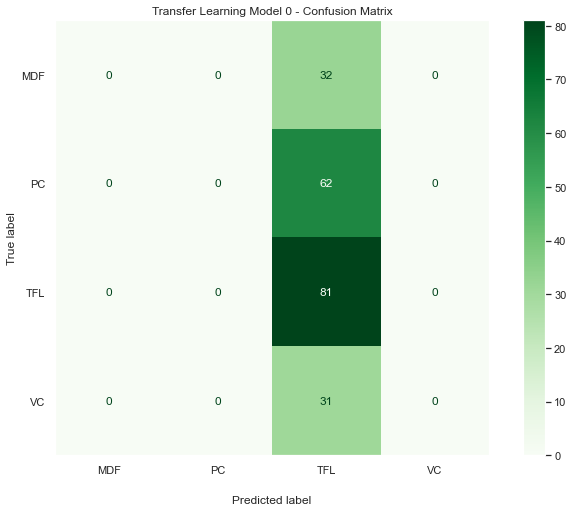

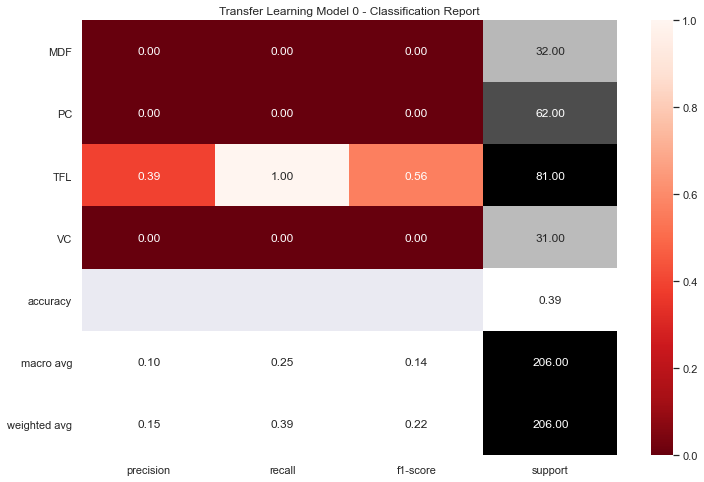

In [64]:
# Show classification report and confusion matrix
show_classification_report_and_confusion_matrix(transfer_model0, 
                                                base_model1_test_data, 
                                                classes, 
                                                'Greens', 
                                                'Reds_r',
                                                'Transfer Learning Model 0 - Confusion Matrix',
                                                'Transfer Learning Model 0 - Classification Report')

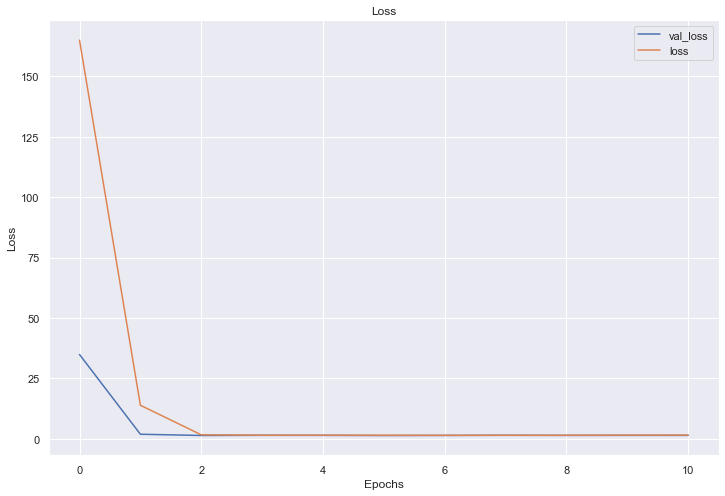

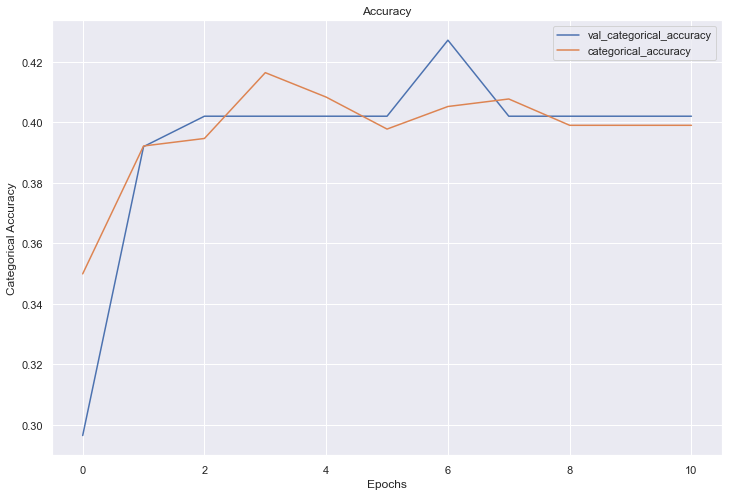

In [65]:
# Plot model loss and accuracy
visualize_training_results(tm0_history)

## Transfer Learning Model 1

Lets try again with the same transfer model, but this time lets integrate the layers that improved the regularization model. So we will add the rescaling, dropout, and data augmentation layers.

In [66]:
# Create transfer model 1
transfer_model1 = models.Sequential([data_augmentation])
transfer_model1.add(layers.experimental.preprocessing.Rescaling(1./255))
transfer_model1.add(cnn_base)
transfer_model1.add(layers.Flatten())
transfer_model1.add(layers.Dense(64, activation='relu'))
transfer_model1.add(layers.Dense(128, activation='relu'))
transfer_model1.add(layers.Dense(256, activation='relu'))
transfer_model1.add(layers.Dense(512, activation='relu'))
transfer_model1.add(layers.Dropout(0.3))
transfer_model1.add(layers.Dense(512, activation='relu'))
transfer_model1.add(layers.Dropout(0.3))
transfer_model1.add(layers.Dense(128, activation='relu'))
transfer_model1.add(layers.Dense(num_classes, activation='softmax'))


In [67]:
# Compile the model
transfer_model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [96]:
# Fit transfer model 1
tm1_history = transfer_model1.fit(
  base_model1_train_data,
  validation_data=base_model1_val_data,
  epochs=epochs,
  class_weight=class_weight,
  callbacks=callbacks
)

Epoch 1/50
51/51 [==============================] - 85s 2s/step - loss: 0.8427 - categorical_accuracy: 0.6532 - val_loss: 0.6677 - val_categorical_accuracy: 0.7186
Epoch 2/50
51/51 [==============================] - 85s 2s/step - loss: 0.7366 - categorical_accuracy: 0.6663 - val_loss: 0.6869 - val_categorical_accuracy: 0.7136
Epoch 3/50
51/51 [==============================] - 84s 2s/step - loss: 0.7639 - categorical_accuracy: 0.6551 - val_loss: 0.6807 - val_categorical_accuracy: 0.6935
Epoch 4/50
51/51 [==============================] - 85s 2s/step - loss: 0.7476 - categorical_accuracy: 0.6905 - val_loss: 0.6342 - val_categorical_accuracy: 0.7085
Epoch 5/50
51/51 [==============================] - 84s 2s/step - loss: 0.6892 - categorical_accuracy: 0.7110 - val_loss: 0.6417 - val_categorical_accuracy: 0.7236
Epoch 6/50
51/51 [==============================] - 84s 2s/step - loss: 0.7320 - categorical_accuracy: 0.6837 - val_loss: 0.6283 - val_categorical_accuracy: 0.7286
Epoch 7/50
51/51

In [97]:
# Evaluate transfer model 1
transfer_model1.evaluate(base_model1_test_data)

7/7 [==============================] - 7s 1s/step - loss: 0.8380 - categorical_accuracy: 0.6748


[0.8379919528961182, 0.6747573018074036]

In [70]:
# Return a summary of our model
transfer_model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 256, 192, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 256, 192, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 8, 6, 2048)        23564800  
_________________________________________________________________
flatten_5 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                6291520   
_________________________________________________________________
dense_18 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_19 (Dense)             (None, 256)              

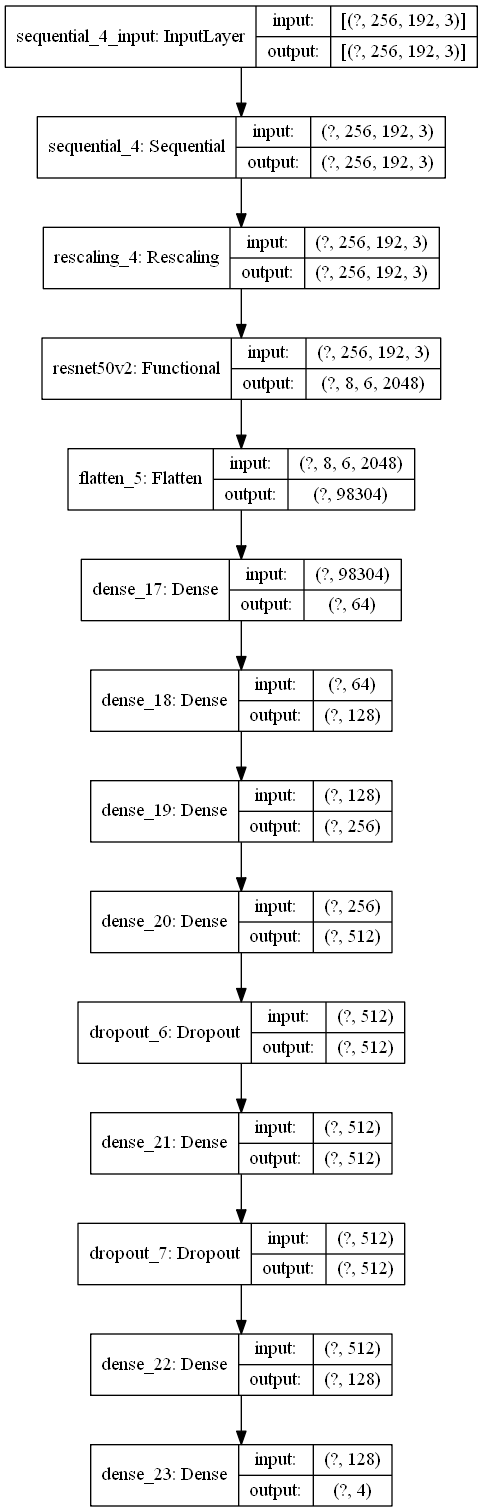

In [71]:
# Return image of model's architecture
plot_model(transfer_model1, show_shapes=True, show_layer_names=True, to_file='Visualizations/TM1-Architecture.png')

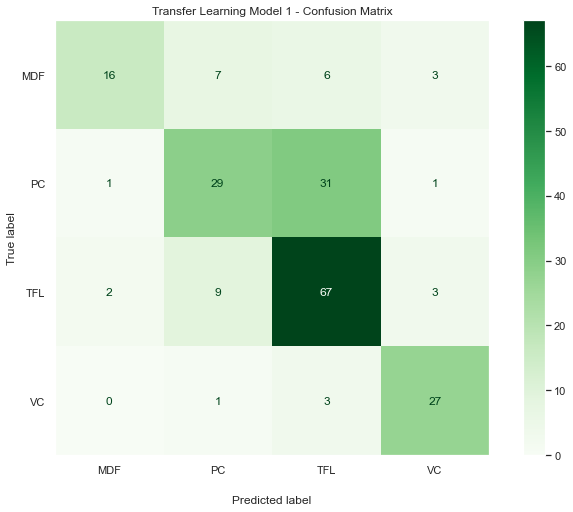

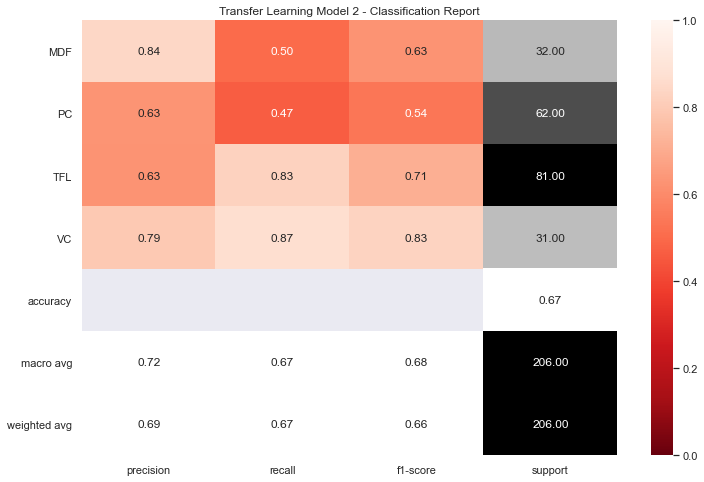

In [98]:
# Show classification report and confusion matrix
show_classification_report_and_confusion_matrix(transfer_model1, 
                                                base_model1_test_data, 
                                                classes, 
                                                'Greens', 
                                                'Reds_r', 
                                                'Transfer Learning Model 1 - Confusion Matrix', 
                                                'Transfer Learning Model 2 - Classification Report')

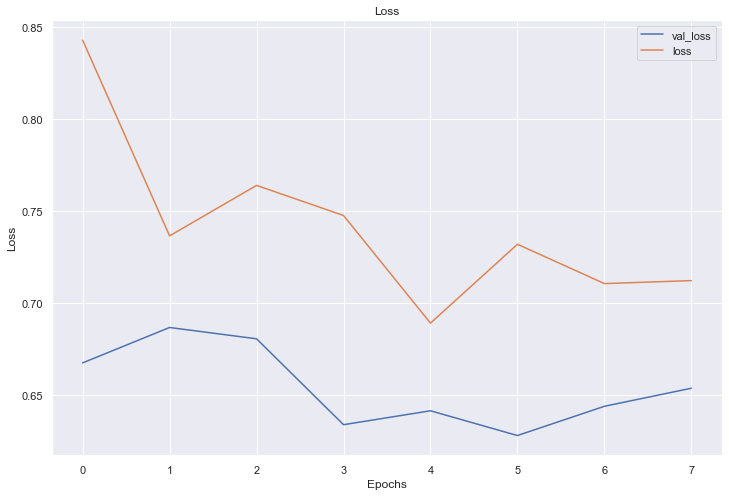

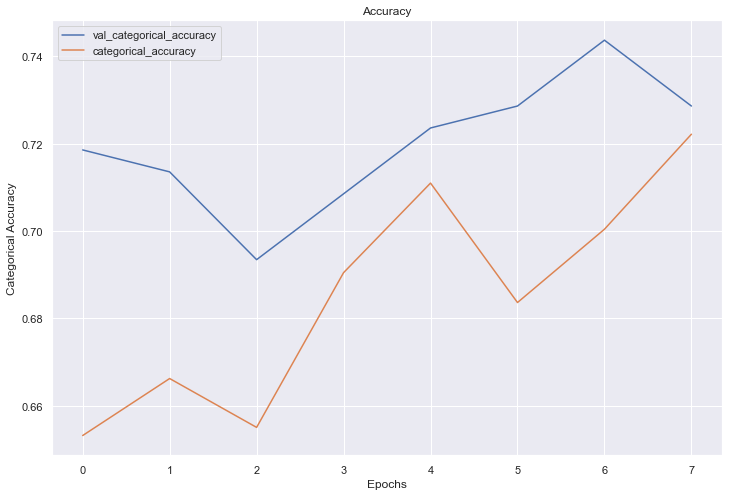

In [99]:
# Plot model loss and accuracy
visualize_training_results(tm1_history)

In [74]:
# Show tensorboard for additional metrics on current and past runs of model
%tensorboard --logdir logs/fit

The results of this model definitely look better than previous models. Lets take a further look at the images that the model was able to predict correctly and what it was not able to predict correctly

In [75]:
# Start with two empty numpy arrays for y_pred and y_test
class_pred_array = np.array([])
y_pred_array = np.array([])
y_test_array =  np.array([])

# split prediction and true values
for x, y in base_model1_test_data:

    # Make numpy array of predictions, take max prediction from each row, and convert to list of values
    y_pred_array = np.concatenate([y_pred_array,
                   np.argmax(transfer_model1.predict(x), axis = -1)])
    
    # Make numpy array of true labels and convert to list
    y_test_array = np.concatenate([y_test_array, np.argmax(y.numpy(), axis=-1)])

# Make numpy array of prediction probabilities
class_pred_array = transfer_model1.predict(base_model1_test_data)

# Make numpy array of images
X_test_array = tf.concat([x for x, y in base_model1_test_data], axis = 0).numpy()

In [76]:
# Identify indexs of correct and incorrect identified images
correct = np.nonzero(y_test_array.astype(int) == y_pred_array.astype(int))[0]
incorrect = np.nonzero(y_test_array.astype(int) != y_pred_array.astype(int))[0]

In [77]:
# Set numpy random seed for choosing correct and incorrect images
np.random.seed(42)

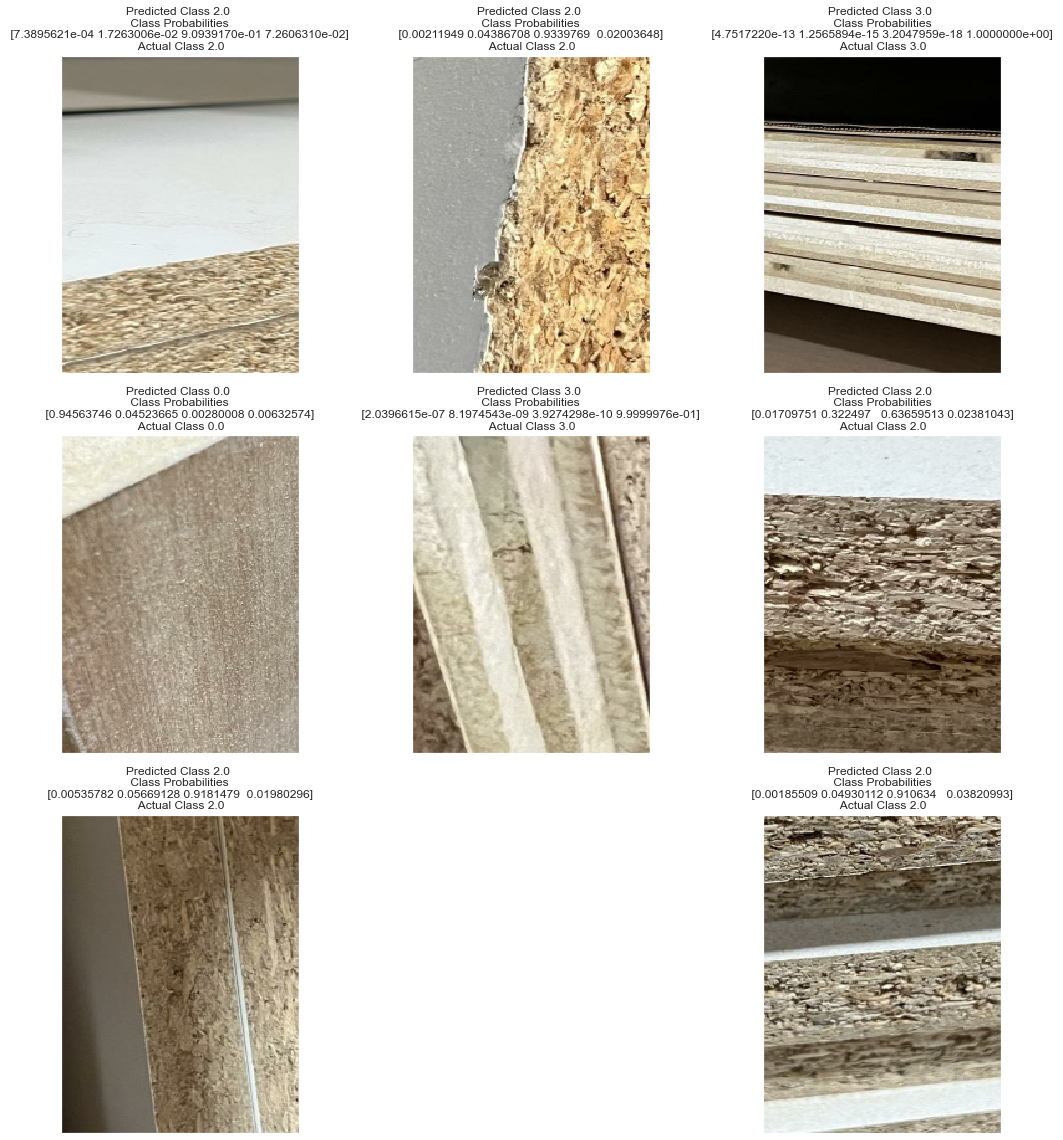

In [104]:
# Use a for loop to iterate through correct predictions,
# display the prediction values for each image and the actual class of the model
correct_sample = np.random.choice(correct, size = 9)
i = 0
plt.figure(figsize=(16,16))
for c in correct_sample:
    ax = plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow((X_test_array[c]).astype(np.uint8), interpolation='none')
    plt.title('Predicted Class {} \n Class Probabilities \n {} \n Actual Class {}'.format(y_pred_array[c], class_pred_array[c], y_test_array[c]))
    plt.tight_layout()
    i += 1
    
plt.savefig('Visualizations/Sample-Correct-Probabilities.png', bbox_inches='tight')        
plt.show();

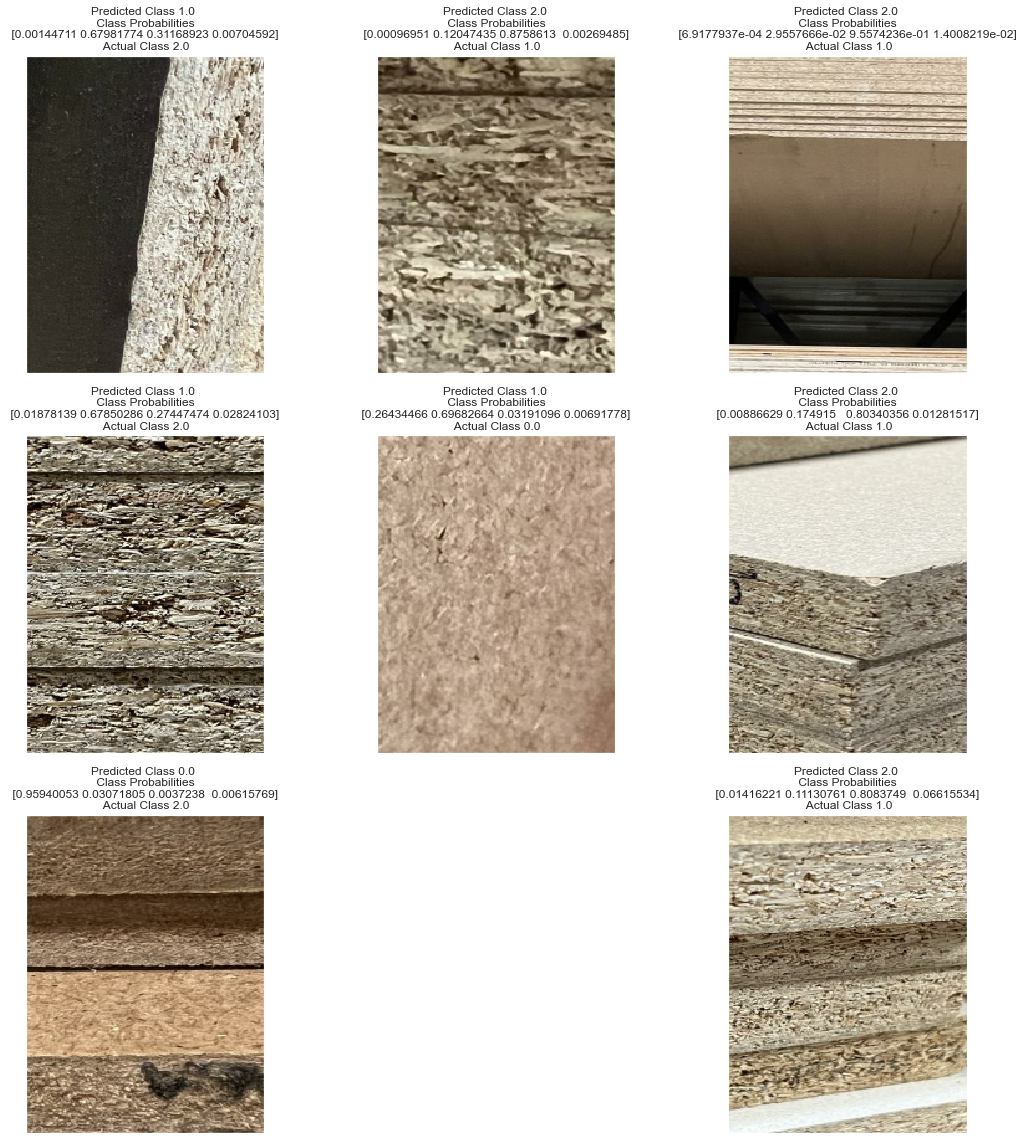

In [105]:
# Use a for loop to iterate through correct predictions,
# display the prediction values for each image and the actual class of the model
incorrect_sample = np.random.choice(incorrect, size = 9)
i = 0
plt.figure(figsize=(16,16))
for c in incorrect_sample:
    ax = plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow((X_test_array[c]).astype(np.uint8), interpolation='none')
    plt.title('Predicted Class {} \n Class Probabilities \n {} \n Actual Class {}'.format(y_pred_array[c], class_pred_array[c], y_test_array[c]))
    plt.tight_layout()
    i += 1

plt.savefig('Visualizations/Sample-Incorrect-Probabilities.png', bbox_inches='tight')        
plt.show();

Clearly our model's confidence in the predicted values are low in the incorrectly predicted pictures. In the correctly predicted pictures, a couple of the TFL and PC predictions are very close as to which one the model intends to go with. Understandably so, considering that the only difference between the two materials is the layer of laminate on the core material itself. 

All of the incorrect predicted images have predictions which fall under 50%, and many of them have values which are very close to other class predictions. It seems that we can see a couple of issues with the incorrect images that give us insight into the problems with our curent dataset. Some TFL / PC images have been labeled incorrectly by the algorithm. TFL mostly comes with a white top and bottom face, but in certain instances it can have a laminate face which is any other color, such as black, gray, and even have a wood grain printed on it.

Also, the model seems to think that cardboard in an image corresponds to the material being identified as Veneer Core. The images that were taken of veneer core typically have a a more brown tone due to the material, and also a number of the images only had a couple of sheets of veneer core with a cardboard top or bottom on it.

For all of these problems, we would need to revise the dataset to have more consistent images, as well as expand the dataset to include more instances where there are exceptions (such as with the TFL problem mentioned above).

All of this is conjecture just by basing it on the entire images that we are presented with and the probabilities in each, maybe we can confirm this thinking by looking at the features of image and see how they relate to the predicted outcome.

## Image Features

We will need to get some idea of what in the image is important to the model itself, so we have a better understanding of how the model works. Lets get two random images (preferably one that is correctly predicted and another that is incorrectly predicted) to see what the model considers as important in its predictions.

True Class: 1.0
Class Predictions: [1.8478476e-03 3.9463010e-02 9.5821893e-01 4.7014694e-04]
Predicted Class: 2.0


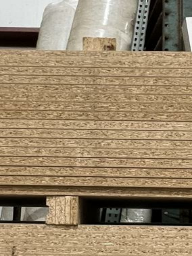

In [80]:
# Set index to pull image from
index = 39
img = X_test_array[index]

# Print true class, predicted class and image
print('True Class:', y_test_array[index])
print('Class Predictions:', class_pred_array[index])
print('Predicted Class:', y_pred_array[index])
tf.keras.preprocessing.image.array_to_img(X_test_array[index])
     

In [81]:
# Rescale image and feed into lime explainer.
img_n = img * (1/255)
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img_n.astype('double'), transfer_model1.predict, top_labels=4,
                                         hide_color=0, num_samples=1000)

# Get image and feature mask from explanation
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

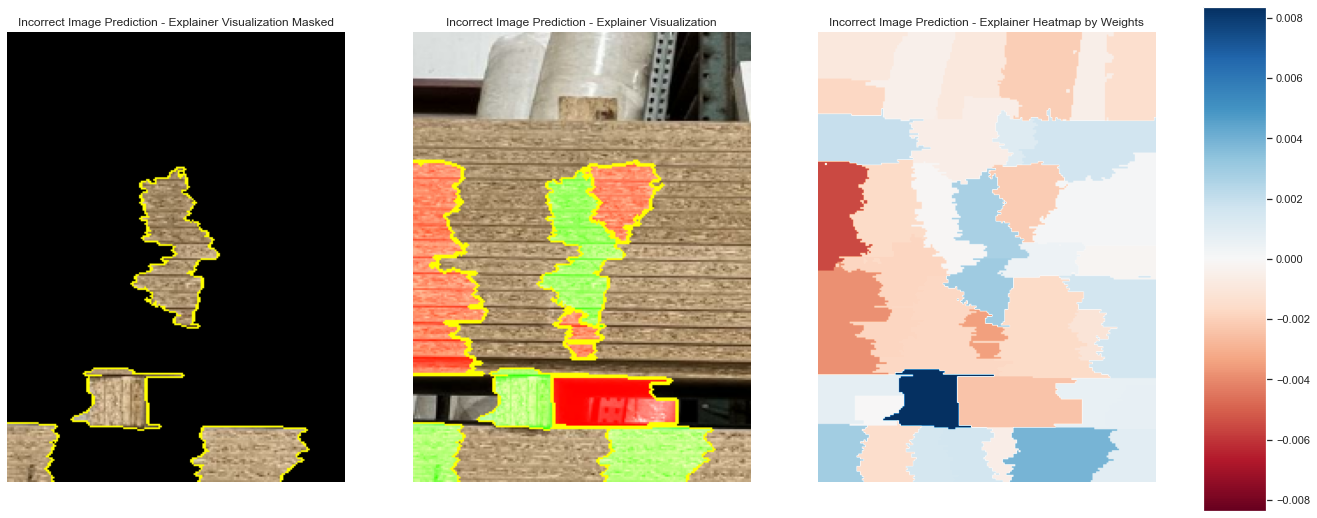

In [82]:
# Using heat-map to highlight the importance of each super-pixel for the model prediction
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 


# Display images with and without mask
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22,10))
ax1.imshow((mark_boundaries(temp_1, mask_1) * 255).astype(np.uint8))
ax2.imshow((mark_boundaries(temp_2, mask_2) * 255).astype(np.uint8))
hm =ax3.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(hm, ax=ax3, shrink=0.5, cax=cbar_ax)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.set_title('Incorrect Image Prediction - Explainer Visualization Masked')
ax2.set_title('Incorrect Image Prediction - Explainer Visualization')
ax3.set_title('Incorrect Image Prediction - Explainer Heatmap by Weights')

plt.savefig('Visualizations/TM1-Incorrect_Image_Explainer.png', bbox_inches='tight')        
plt.show();

The heat map and the masks clearly show that the image was taking input from the background of the image. So this verifies our suspicion that the backgrund of the images are confusing the predictions. In this case, it was supposed to be a correct predicition of Particle Core, but it guessed TFL because of some of the white in the background, which has the same coloring as most of the white TFL sheets.

Lets take a look at one of the correct predictions in comparison

True Class: 1.0
Class Predictions: [0.17976788 0.30452195 0.448258   0.06745213]
Predicted Class: 2.0


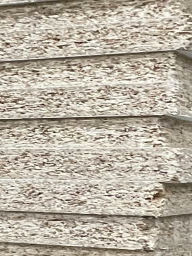

In [83]:
# Set index to pull image from
index = 41
img = X_test_array[index]

# Print true class, predicted class and image
print('True Class:', y_test_array[index])
print('Class Predictions:', class_pred_array[index])
print('Predicted Class:', y_pred_array[index])
tf.keras.preprocessing.image.array_to_img(X_test_array[index])
     

In [84]:
# Rescale image and feed into lime explainer.
img_n = img * (1/255)
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img_n.astype('double'), transfer_model1.predict, top_labels=4,
                                         hide_color=0, num_samples=1000)

# Get image and feature mask from explanation
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

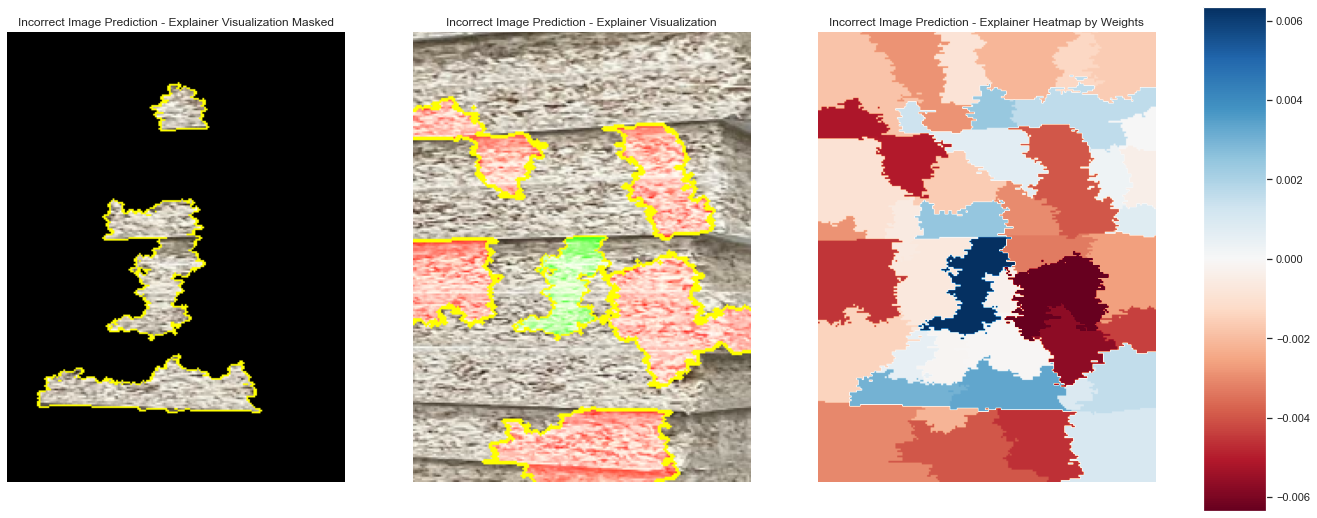

In [85]:
# Using heat-map to highlight the importance of each super-pixel for the model prediction
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 


# Display images with and without mask
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22,10))
ax1.imshow((mark_boundaries(temp_1, mask_1) * 255).astype(np.uint8))
ax2.imshow((mark_boundaries(temp_2, mask_2) * 255).astype(np.uint8))
hm = ax3.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(hm, ax=ax3, shrink=0.5, cax=cbar_ax)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.set_title('Incorrect Image Prediction - Explainer Visualization Masked')
ax2.set_title('Incorrect Image Prediction - Explainer Visualization')
ax3.set_title('Incorrect Image Prediction - Explainer Heatmap by Weights')

plt.savefig('Visualizations/TM1-Correct_Image_Explainer.png', bbox_inches='tight')        
plt.show();

From the heatmap it looks like the model is picking up on areas where there is more textujre in order to identify the material, which is exactly what it needs, as the texture variation between all the materials are somewhat subtle and rely on recognition of texture.

## Final Model Interpretation and Evaluation

After modeling our data, our final model results just miss the required criteria for this exercise. But we were extremely close to where we needed to be for this initial iteration of this image classifier. At 68% we only missed our initial goal of 70% by a few percentage points.

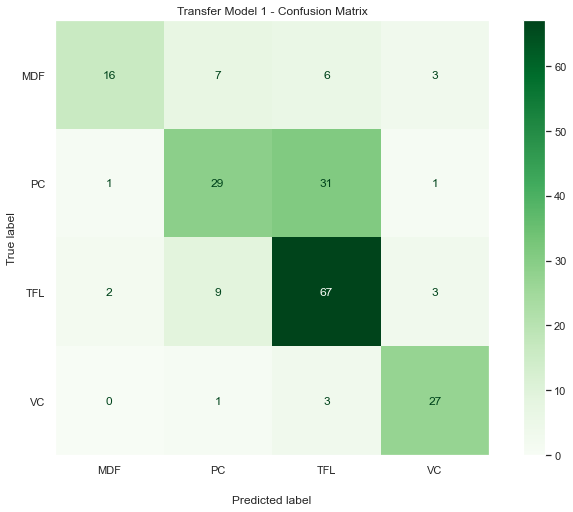

In [100]:
# Start with two empty numpy arrays for y_pred and y_test
y_pred = np.array([])
y_test =  np.array([])

# split prediction and true values
for x, y in base_model1_test_data:

    # Make numpy array of predictions, take max prediction from each row, and convert to list of values
    y_pred = np.concatenate([y_pred,
                   np.argmax(transfer_model1.predict(x), axis = -1)])

    # Make numpy array of true labels and convert to list
    y_test = np.concatenate([y_test, np.argmax(y.numpy(), axis=-1)])

# Display a confusion matrix using the test and predicted values
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap = 'Greens')
disp.ax_.set_title('Transfer Model 1 - Confusion Matrix')
disp.ax_.xaxis.labelpad = 20
plt.grid(False)

plt.savefig('Visualizations/TM1-Confusion_Matrix.png', bbox_inches='tight')        
plt.show();

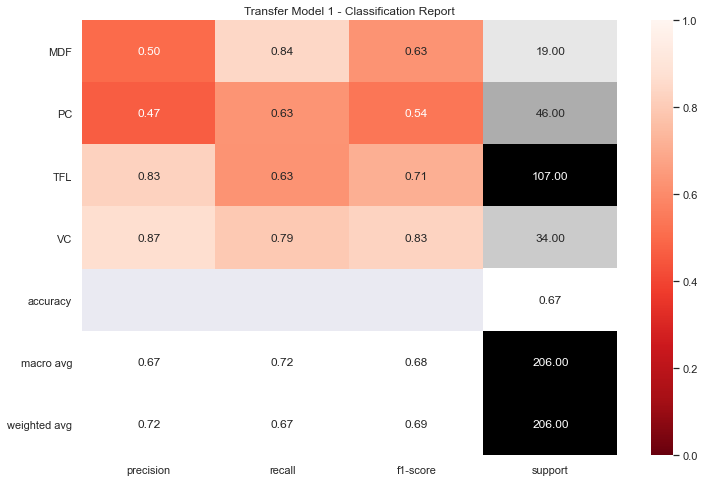

In [103]:
# Create dataframe of classification report
df = pd.DataFrame(classification_report(y_pred, 
                                    y_test, 
                                    target_names=classes, 
                                    digits=2,
                                    output_dict=True)).T

# Create fig and ax for classification report
fig, ax = plt.subplots()

# Mask all classification report cells except class metric cells and create heatmap
mask = np.zeros((df.shape))
mask[:, -1] = True
mask[4:7, :] = True
ax = sns.heatmap(pd.DataFrame(df), mask=mask, vmin=0, vmax=1, cmap='Reds_r', annot=True, fmt='.2f')

# Mask all classification report cells except class support cells and create heatmap
mask = np.zeros(df.shape)
mask[:,:3] = True 
mask[5:7, :] = True
ax = sns.heatmap(df, mask=mask, annot=True, cmap='Greys', cbar=False, fmt='.2f') 

# Mask all classification report cells except macro avg and weighted avg rows and create heatmap
mask = np.zeros(df.shape)
mask[0:5, :] = True
ax = sns.heatmap(df, mask=mask, annot=True, cmap='Greys', cbar=False, fmt='.2f') 

# Specify classification report title and ytick direction
plt.title('Transfer Model 1 - Classification Report')
plt.yticks(rotation = 0);

plt.savefig('Visualizations/TM1-Classification_Report.png', bbox_inches='tight')        
plt.show();

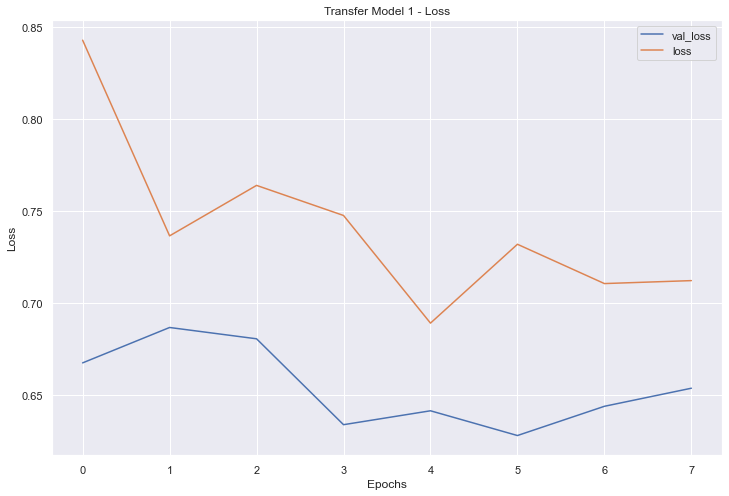

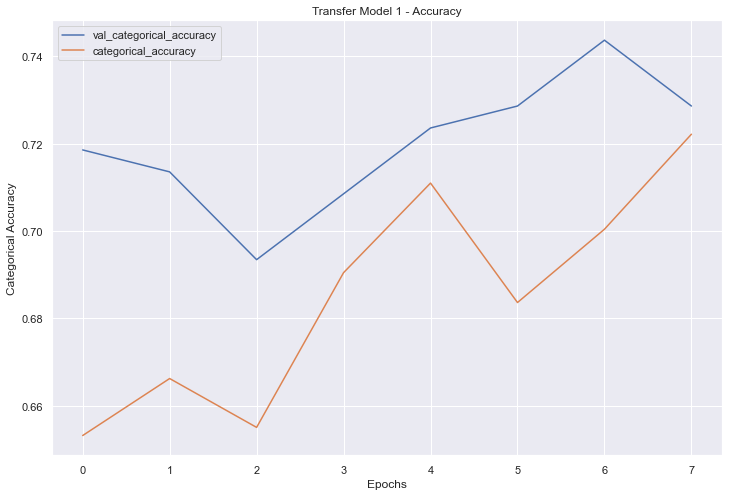

In [102]:
# Plot loss for each epoch
history = tm1_history.history
plt.figure()
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Transfer Model 1 - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('Visualizations/TM1-Loss.png', bbox_inches='tight')    
plt.show()

# Plot accuracy for each epoch
plt.figure()
plt.plot(history['val_categorical_accuracy'])
plt.plot(history['categorical_accuracy'])
plt.legend(['val_categorical_accuracy', 'categorical_accuracy'])
plt.title('Transfer Model 1 - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')

plt.savefig('Visualizations/TM1-Accuracy.png', bbox_inches='tight')        
plt.show();

## Recommendations

- Collect data again with additional time to create a more consistent method for obtaining quality data that is at the same distance from the object, and in the same lighting conditions. This setup would have to be engineered for each interval in the working process where an image must be taken.
- Increase the amount of data that the algorithm trains on. While 2,000 images is a good start, 10,000 or 20,000 would be even better for improving the performance of the model.
- Each working interval should a similar hardware setup in order to take consistent images at each interval. A dedicated area with a mounted camera and a lighting strategy should exist in (1) the warehouse for incoming skids for material, (2) at the panel saw for scrap parts, and (3) at each CNC router to confirm the material on the machine prior to cutting.
- After a recollection of data, additional fine tuning of the transfer learning model would be required in order to cope with the new conditions.
- We tried a number of different models in the notebook above, but better results could be obtained by testing the final model through additional iterations.

## Conclusion

In conclusion, we were close to our required results, but just missed the mark. From looking at the incorrect and correct images in the classification, it is clear that refining the data collection would be imperative in order to improve results. The conversation of consistent data collection would need to take place with the hardware team that plans to create the required setups. This would give us better insight into the data that will be collected. 

In addition, using a larger dataset, and refining our current model would also assist in being able to further results in the right direction. 